In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from statsmodels import graphics
from IPython.display import display
pd.options.display.max_columns = None

# Regression - GLMs


## Exercise 1: Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

- **FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.
- **LIVE_BAIT:** A binary variable indicating whether live bait was used.
- **CAMPER:** Whether the fishing group used a camper van.
- **PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.
- **CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (`FISH_COUNT`) by a camping group based on the values of `LIVE_BAIT`, `CAMPER`, `PERSONS` and `CHILDREN` variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort we went through to find a fish dataset for a count problem pun. 😛

In [2]:
# data check
df = pd.read_csv('../data/fish.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   LIVE_BAIT   250 non-null    int64
 1   CAMPER      250 non-null    int64
 2   PERSONS     250 non-null    int64
 3   CHILDREN    250 non-null    int64
 4   FISH_COUNT  250 non-null    int64
dtypes: int64(5)
memory usage: 9.9 KB


,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
88,1,1,4,0,149


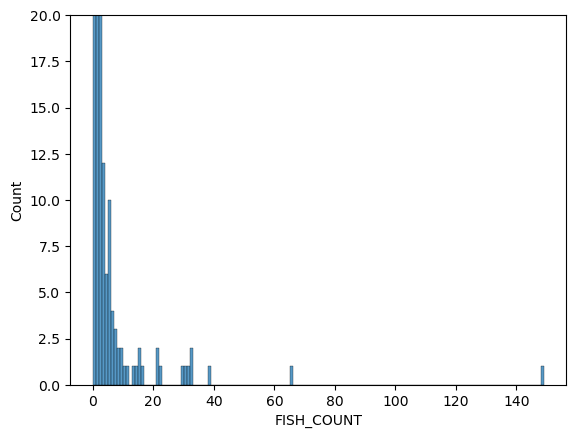

In [3]:
sns.histplot(df.FISH_COUNT, binwidth=1)
plt.ylim(0, 20)

df[df.FISH_COUNT == df.FISH_COUNT.max()]

# distribution has one wild outlier, how do 4 people catch 149 fish??

<AxesSubplot:xlabel='FISH_COUNT', ylabel='Count'>

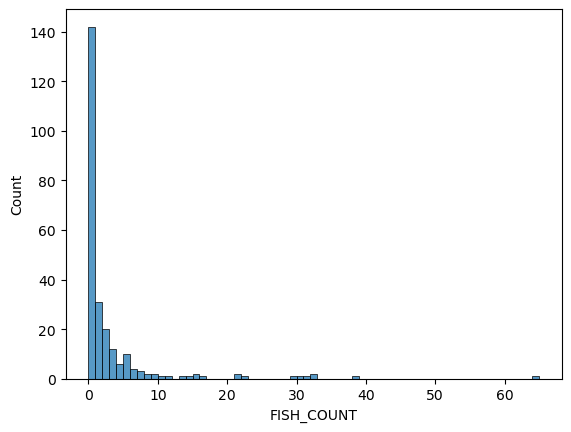

In [4]:
# remove outlier and save in a different table for later comparison
df_ = df.drop(df[df.FISH_COUNT == df.FISH_COUNT.max()].index)

sns.histplot(df_.FISH_COUNT, binwidth=1)

# can see that there is an inflated number of zeros

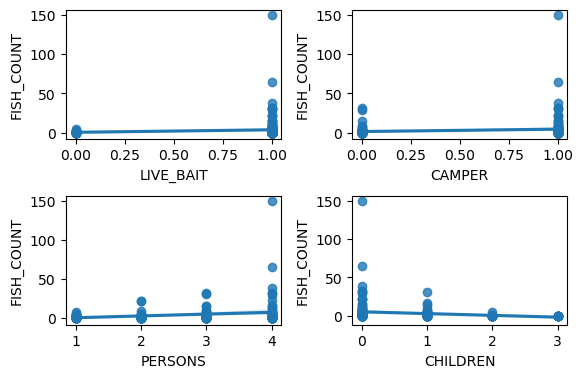

In [5]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.tight_layout(pad=2)

sns.regplot(x=df.LIVE_BAIT, y=df.FISH_COUNT, ax=ax1)
sns.regplot(x=df.CAMPER, y=df.FISH_COUNT, ax=ax2)
sns.regplot(x=df.PERSONS, y=df.FISH_COUNT, ax=ax3)
sns.regplot(x=df.CHILDREN, y=df.FISH_COUNT, ax=ax4)
plt.show()

# all discrete and non-normal data but can generally see some trends in how each feature affects fish count

<AxesSubplot:>

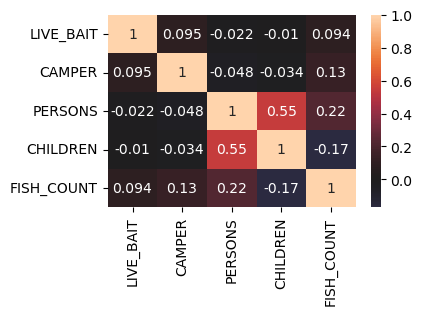

In [6]:
fig = plt.figure(figsize=(4,2.5))
sns.heatmap(df.corr(), annot=True, center=0)

# collinearity with persons and children is expected

In [7]:
# setting up data

X = sm.add_constant(df.drop('FISH_COUNT', axis=1))
y = df.FISH_COUNT

In [8]:
poisson_model = sm.GLM(y, X, sm.families.Poisson()).fit()

dispersion = poisson_model.pearson_chi2/poisson_model.df_resid
print(f'Dispersion parameter: {dispersion}')

# since the dispersion is much greater than 1 a poisson model is not going to be a good option
# a negative binomial model will be better for handling the large variance

Dispersion parameter: 10.316619388510428


## Zero Inflated Model:

In [9]:
# first try the built-in zero inflated model

zinb_model = sm.ZeroInflatedNegativeBinomialP(y, X, p=1).fit(maxiter=100)

zinb_model.summary()

# this model shows a positive correlation to number of fish for all independent variables except children

Optimization terminated successfully.
         Current function value: 1.603996
         Iterations: 56
         Function evaluations: 58
         Gradient evaluations: 58


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                        FISH_COUNT   No. Observations:                  250
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      245
Method:                                      MLE   Df Model:                            4
Date:                           Sun, 05 Mar 2023   Pseudo R-squ.:                  0.1366
Time:                                   17:31:55   Log-Likelihood:                -401.00
converged:                                  True   LL-Null:                       -464.44
Covariance Type:                       nonrobust   LLR p-value:                 1.809e-26
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -15.5556    533.342     -0.029      0.977   -1060.886    1029.775
const            -1.6473      0.438     -3.757      0.000      -2.507      -0.788
LIVE_BAIT         0.8985      0.327      2.748      0.006       0.258       1.539
CAMPER            0.6496      0.191      3.398      0.001       0.275       1.024
PERSONS           0.7907      0.082      9.627      0.000       0.630       0.952
CHILDREN         -1.4772      0.166     -8.909      0.000      -1.802      -1.152
alpha             8.4659      1.552      5.453      0.000       5.423      11.509
=================================================================================
"""

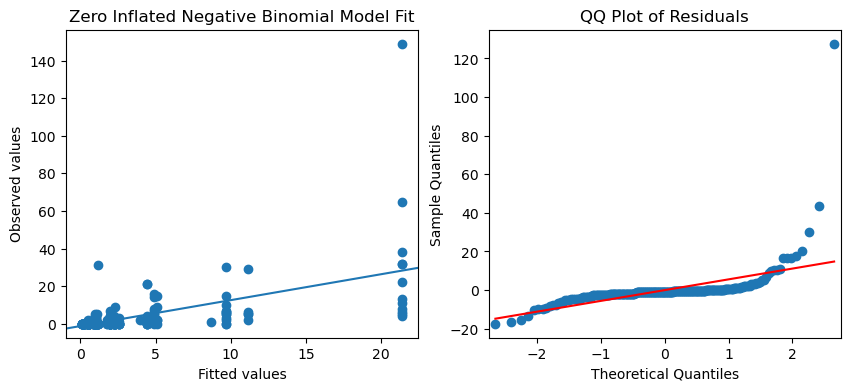

              precision    recall  f1-score   support

           0       0.89      0.40      0.55       142
           1       0.17      0.48      0.25        31
           2       0.12      0.20      0.15        20
           3       0.00      0.00      0.00        12
           4       0.04      0.17      0.06         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          22       0.00    

In [10]:
# plots and report to see how well the model fits observed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

model = zinb_model
exog = X
y = y

ax1.scatter(model.predict(exog), y)
line_fit = sm.OLS(y, sm.add_constant(model.predict(exog))).fit()
sm.graphics.abline_plot(model_results=line_fit, ax=ax1)
ax1.set_title('Zero Inflated Negative Binomial Model Fit')
ax1.set_ylabel('Observed values')
ax1.set_xlabel('Fitted values')

graphics.gofplots.qqplot(model.resid, line='r', ax=ax2)
ax2.set_title('QQ Plot of Residuals')
plt.show()

print(metrics.classification_report(y, model.predict(exog).astype(int), zero_division=0))

# this doesn't appear to be a great model with an accuracy of 31%
# the precision for determining a zero is decent but that's it

## Two-stage Model:

In [11]:
# next try two stage modeling as in the lecture to first get a probability for zero or not zero

# make the model
zero_model = sm.Logit((y > 0), X).fit()

# create the table used for the second stage
X_stg2 = pd.DataFrame(X).copy()
X_stg2['stage1'] = zero_model.predict(X_stg2)

Optimization terminated successfully.
         Current function value: 0.495335
         Iterations 6


In [12]:
# fit GLM using negative binomial on the new table

negbin_model = sm.GLM(y, X_stg2, sm.families.NegativeBinomial()).fit()

negbin_model.summary()

# coefficients in this model still suggest children have a negative effect on how many fish are caught
# live bait has the strongest positive effect on number of fish

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  250
Model:                            GLM   Df Residuals:                      244
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -406.13
Date:                Sun, 05 Mar 2023   Deviance:                       293.93
Time:                        17:31:56   Pearson chi2:                     693.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.7566
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1109      0.412     -7.557      0.000      -3.918      -2.304
LIVE_BAIT      1.9247      0.435      4.430      0.000       1.073       2.776
CAMPER         0.9603      0.332      2.894      0.004       0.310       1.611
PERSONS        1.5322      0.340      4.510      0.000       0.866       2.198
CHILDREN      -2.6861      0.651     -4.127      0.000      -3.962      -1.411
stage1        -2.4238      1.655     -1.465      0.143      -5.667       0.820
==============================================================================
"""

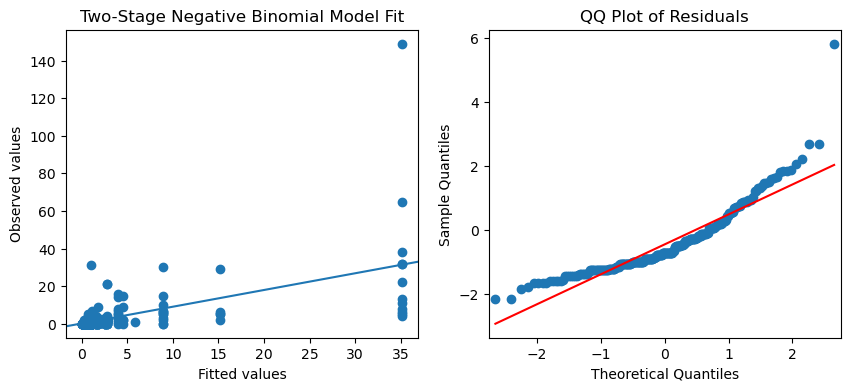

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       142
           1       0.17      0.35      0.23        31
           2       0.17      0.20      0.19        20
           3       0.27      0.25      0.26        12
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         2
          22       0.00    

In [13]:
# plots and report to see how well the model fits observed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

model = negbin_model
exog = X_stg2
y = y

ax1.scatter(model.predict(exog), y)
line_fit = sm.OLS(y, sm.add_constant(model.predict(exog))).fit()
sm.graphics.abline_plot(model_results=line_fit, ax=ax1)
ax1.set_title('Two-Stage Negative Binomial Model Fit')
ax1.set_ylabel('Observed values')
ax1.set_xlabel('Fitted values')

graphics.gofplots.qqplot(model.resid_deviance, line='r', ax=ax2)
ax2.set_title('QQ Plot of Residuals')
plt.show()

print(metrics.classification_report(y, model.predict(exog).astype(int), zero_division=0))

# this model has better performance but still not very good
# the f1 score of .71 for determining zeros is not too bad though
# the model also never predicts any more than 35 fish despite the original data going to 149

## Two-Stage Without Outliers:

In [14]:
# try modelling data without outliers to see if there is improved performance

df_no_outliers = df_.drop(df_[df_.FISH_COUNT == df_.FISH_COUNT.max()].index)

X2 = sm.add_constant(df_no_outliers.drop('FISH_COUNT', axis=1))
y2 = df_no_outliers.FISH_COUNT

In [15]:
# first stage
zero_model2 = sm.Logit((y2 > 0), X2).fit()

# create the table used for the second stage, as in lecture
X2_stg2 = pd.DataFrame(X2)
X2_stg2['stage1'] = zero_model.predict(X2_stg2)

Optimization terminated successfully.
         Current function value: 0.499054
         Iterations 6


In [16]:
# fit GLM using negative binomial on the new table

negbin_model2 = sm.GLM(y2, X2_stg2, sm.families.NegativeBinomial()).fit()

negbin_model2.summary()

# comparing the two models this model has a lower pseudo R^2 so might not even fit as well

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  248
Model:                            GLM   Df Residuals:                      242
Model Family:        NegativeBinomial   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -392.04
Date:                Sun, 05 Mar 2023   Deviance:                       288.12
Time:                        17:31:56   Pearson chi2:                     717.
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6317
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7919      0.416     -6.709      0.000      -3.608      -1.976
LIVE_BAIT      1.5818      0.436      3.624      0.000       0.726       2.437
CAMPER         0.5939      0.338      1.755      0.079      -0.069       1.257
PERSONS        1.1032      0.349      3.161      0.002       0.419       1.787
CHILDREN      -1.9032      0.660     -2.885      0.004      -3.196      -0.610
stage1        -0.6957      1.679     -0.414      0.679      -3.987       2.596
==============================================================================
"""

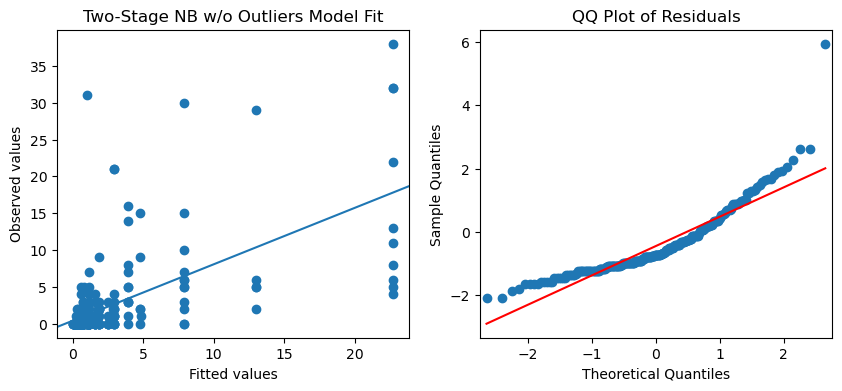

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       142
           1       0.17      0.35      0.23        31
           2       0.17      0.20      0.19        20
           3       0.27      0.25      0.26        12
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         4
           7       0.08      0.33      0.13         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1
          21       0.00    

In [17]:
# plots and report to see how well the model fits observed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

model = negbin_model2
exog = X2_stg2
y = y2

ax1.scatter(model.predict(exog), y)
line_fit = sm.OLS(y, sm.add_constant(model.predict(exog))).fit()
sm.graphics.abline_plot(model_results=line_fit, ax=ax1)
ax1.set_title('Two-Stage NB w/o Outliers Model Fit')
ax1.set_ylabel('Observed values')
ax1.set_xlabel('Fitted values')

graphics.gofplots.qqplot(model.resid_deviance, line='r', ax=ax2)
ax2.set_title('QQ Plot of Residuals')
plt.show()

print(metrics.classification_report(y, model.predict(exog).astype(int), zero_division=0))

# this model doesn't perform any better than the model containing the outliers
# since removing data is not usually recommended the two-stage negative binomial model is the best of the three